### Coda, in which all of these concepts and practices are elucidated, using a synthetic dataset:

In order to see how data scaling affects classification challenges, we'll synthesize a dataset. This is a good approach so that we know exactly what is going on in it. In the code chunk below, we use scikit-learn's make_blobs function to generate 2000 data points that are in 4 clusters (each data point has 2 predictor variables and 1 target variable):

In [2]:
# Generate some clustered data (blobs!)
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
n_samples=2000
X, y = make_blobs(n_samples, centers=4, n_features=2,
                  random_state=0)
print('The shape of X is %s.' % str(X.shape))
print('The shape of y is %s.' % str(y.shape))

The shape of X is (2000, 2).
The shape of y is (2000,).


#### Plotting the synthesized data


We'll now plot in the plane the data that we've synthesized. Each axis is a predictor variable and the colour is a key to the target variable:

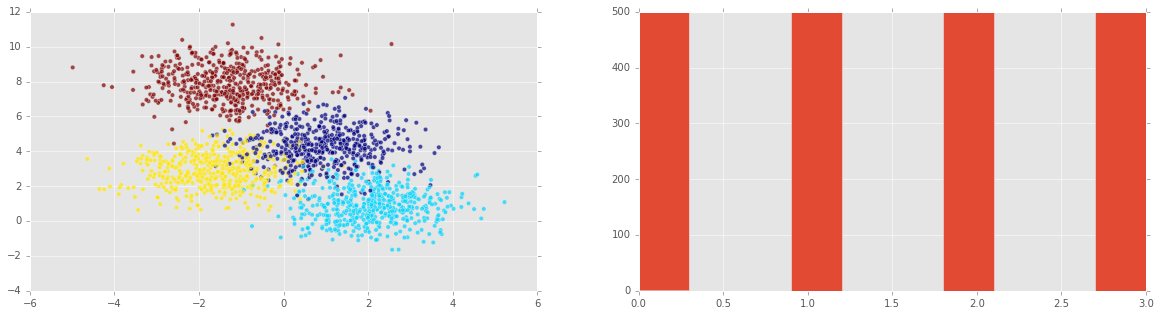

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot') # Make the graphs a bit prettier
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.scatter(X[:,0] , X[:,1],  c = y, alpha = 0.7);
plt.subplot(1, 2, 2);
plt.hist(y)
plt.show()

*Note: we can see in the 2nd plot that all possible target variables are equally represented. In this case (or even if they are approximately equally represented), we say that the class y is balanced.*

I now want to plot histograms of the features (predictor variables). The easiest way to do this (that I know of) is converting numpy array to a pandas dataframe and calling pd.DataFrame.hist():

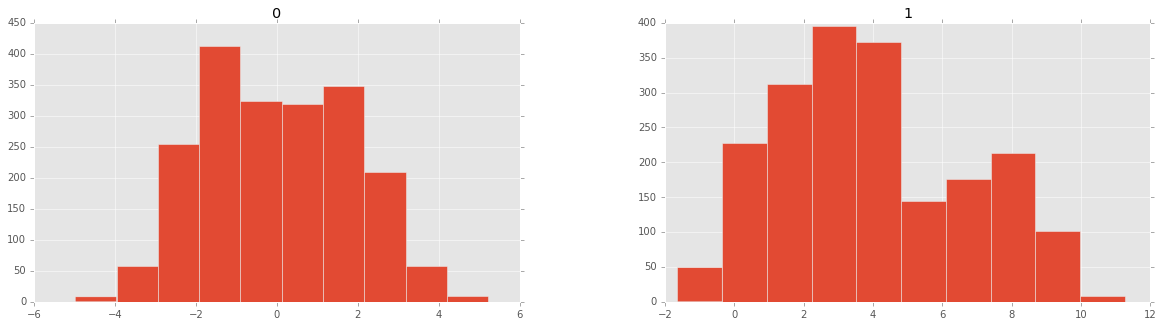

In [5]:
import pandas as pd
df = pd.DataFrame(X)
pd.DataFrame.hist(df, figsize=(20,5));

Let's now split into test/train & plot both sets:

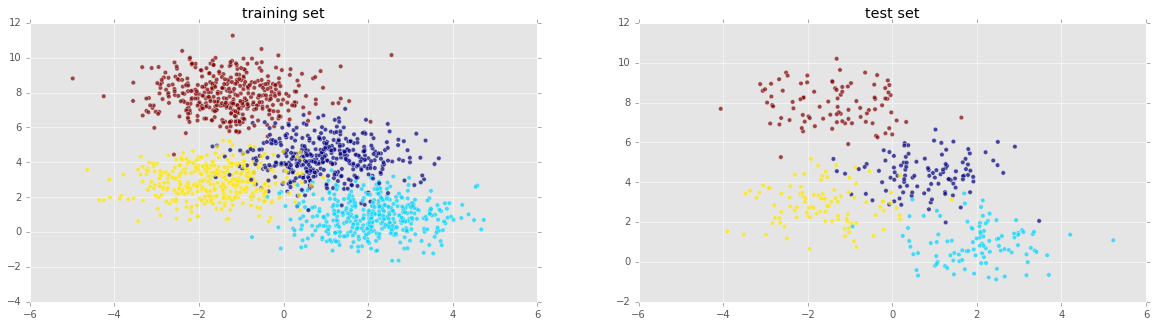

In [6]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.title('training set')
plt.scatter(X_train[:,0] , X_train[:,1],  c = y_train, alpha = 0.7);
plt.subplot(1, 2, 2);
plt.scatter(X_test[:,0] , X_test[:,1],  c = y_test, alpha = 0.7);
plt.title('test set')
plt.show()

Looking good! Now let's instantiate a k-Nearest Neighbors voting classifier and train it on our training set:

In [8]:
from sklearn import neighbors, linear_model
knn = neighbors.KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)

Now that we have trained our model we can fit it to our test set and compute the accuracy:

In [9]:
print('k-NN score for test set: %f' % knn_model.score(X_test, y_test))

k-NN score for test set: 0.935000


We can also re-fit it to our training set and compute the accuracy. We would expect it to perform better on the training set than the test set:

In [10]:
print('k-NN score for training set: %f' % knn_model.score(X_train, y_train))

k-NN score for training set: 0.941875


#### Now with scaling

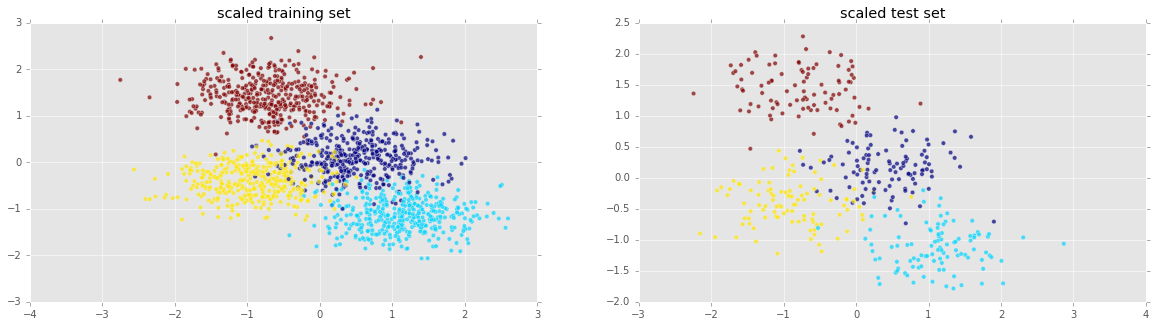

In [11]:
from sklearn.preprocessing import scale
# from sklearn.preprocessing import StandardScaler
Xs = scale(X)
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.scatter(Xs_train[:,0] , Xs_train[:,1],  c = y_train, alpha = 0.7);
plt.title('scaled training set')
plt.subplot(1, 2, 2);
plt.scatter(Xs_test[:,0] , Xs_test[:,1],  c = y_test, alpha = 0.7);
plt.title('scaled test set')
plt.show()

In [12]:
knn_model_s = knn.fit(Xs_train, y_train)
print('k-NN score for test set: %f' % knn_model_s.score(Xs_test, y_test))

k-NN score for test set: 0.935000


It doesn't perform any better. Probably because both features were already around the same range. It really makes sense to scale when variables have widely varying ranges. To see this in action, we're going to add another feature. Moreover, this feature will bear no relevance to the target variable: it will be mere noise.

#### Adding noise to the signal:

We add a third variable of Gaussian noise with mean 0 and variable standard deviation $\sigma$. We'll call $\sigma$ the strength of the noise and we'll see that the stronger the noise, the worse the performance of k-Nearest Neighbours.

In [13]:
# Add noise column to predictor variables
ns = 10**(3) # Strength of noise term
newcol = np.transpose([ns*np.random.randn(n_samples)])
Xn = np.concatenate((X, newcol), axis = 1)
print('The shape of the new feature array is %s.' % str(Xn.shape))

The shape of the new feature array is (2000, 3).


We'll now use the mplot3d package to plot the 3D data:

(-10000, 10000)

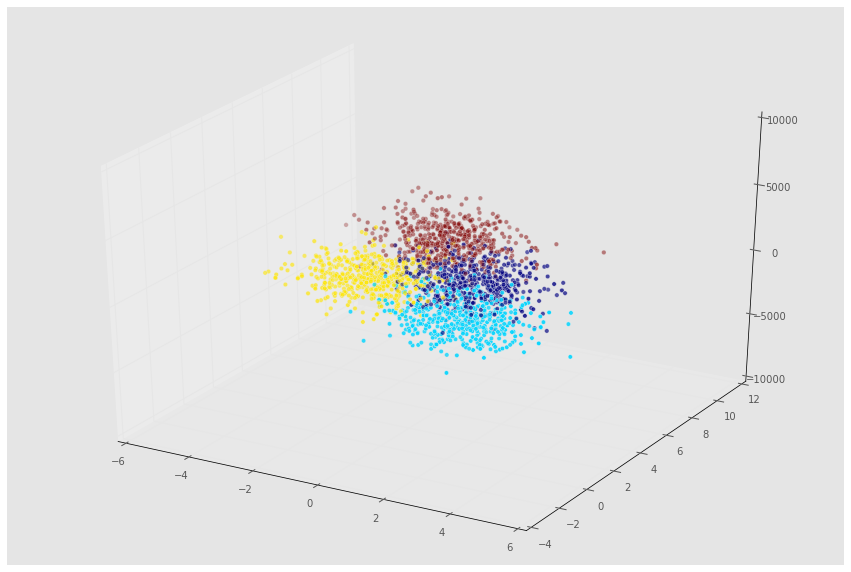

In [14]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10));
ax = fig.add_subplot(111, projection='3d' , alpha = 0.5);
ax.scatter(Xn[:,0], Xn[:,1], Xn[:,2], c = y);
ax.set_zlim((-10*ns,10*ns))

Now let's see how our model performs on the new data:

In [17]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size=0.2, random_state=42)
knn = neighbors.KNeighborsClassifier()
knn_model = knn.fit(Xn_train, y_train)
print('k-NN score for test set: %f' % knn_model.score(Xn_test, y_test))

k-NN score for test set: 0.332500


This is a horrible model! How about we scale and check out performance?

In [18]:
Xns = scale(Xn)
s = int(.2*n_samples)
Xns_train = Xns[s:]
y_train = y[s:]
Xns_test = Xns[:s]
y_test = y[:s]
knn = neighbors.KNeighborsClassifier()
knn_models = knn.fit(Xns_train, y_train)
print('k-NN score for test set: %f' % knn_models.score(Xns_test, y_test))

k-NN score for test set: 0.922500


Great, so after scaling the data, the model performs as well as were there no noise introduced. Let's now check out the model performance as a function of noise.

#### The stronger the noise, the bigger the problem:

We're now going to see how the noise strength effects model accuracy. As we'll need to use the same code a number of times, let's actually wrap up the main parts in a small function:

In [19]:
def accu( X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    knn = neighbors.KNeighborsClassifier()
    knn_model = knn.fit(X_train, y_train)
    return(knn_model.score(X_test, y_test))

In [20]:
noise = [10**i for i in np.arange(-1,6)]
A1 = np.zeros(len(noise))
A2 = np.zeros(len(noise))
count = 0
for ns in noise:
    newcol = np.transpose([ns*np.random.randn(n_samples)])
    Xn = np.concatenate((X, newcol), axis = 1)
    Xns = scale(Xn)
    A1[count] = accu( Xn, y)
    A2[count] = accu( Xns, y)
    count += 1

We now plot accuracy as a function of noise strength (note log x axis):

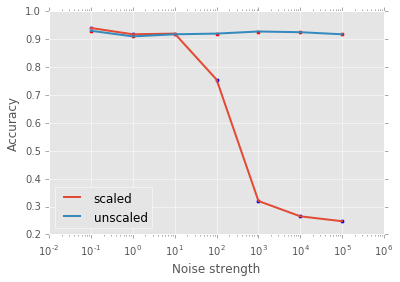

In [21]:
plt.scatter( noise, A1 )
plt.plot( noise, A1, label = 'scaled', linewidth = 2)
plt.scatter( noise, A2 , c = 'r')
plt.plot( noise, A2 , label = 'unscaled', linewidth = 2)
plt.xscale('log')
plt.xlabel('Noise strength')
plt.ylabel('Accuracy')
plt.legend(loc=3);

**Exercise for the avid reader:** try out fitting a logistic regression model to the above synthesized datasets and check out the model performance. How is accuracy a function of noise strength for scaled and unscaled data, respectively?

We have seen the essential place occupied in the data scietific pipeline by preprocessing, in its scaling and centering incarnation, and we have done so to promote a holistic approach to the challenges of machine learning. In future articles, I hope to extend this discussion to other types of preprocessing, such as transformations of numerical data and preprocessing of categorical data, both essential aspects of any data scientists's toolkit.